<a href="https://colab.research.google.com/github/cutlersimpson/GU-ML/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [325]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [326]:
# Set variables to be used
template = 'ggplot2'
test_size = 0.75 # I had to use this large of a test size to ensure all of the labels were included

In [327]:
# Read in data
data = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_RSEM_42cases.txt', sep='\t', header=(0))
annotation_data = pd.read_csv('https://github.com/PineBiotech/omicslogic/blob/master/TCGA_43_clinical.csv?raw=true', index_col=None)

# Change annotation_data naming to match with data naming
annotation_data['Variable'] = annotation_data['Variable'].str.replace('-', '_')
annotation_data['Variable'] = annotation_data['Variable'].str[:16]
stage = annotation_data[["Variable", "pathologic_stage"]]

features = data.iloc[1:, 0].values

data=data.drop(['ID'], axis = 1) 
dataT = np.transpose(data)

# Merge dataframes so stage is mapped to other data
all_data = stage.merge(dataT, how='inner', left_on='Variable', right_on=dataT.index.values)

#save numeric data separate from labels (X = numeric matrix, y=labels)
X = all_data.iloc[:, 2:].values
y = all_data.iloc[:, 1].values

#save class names
classes = np.unique(y)
n_classes = len(classes)

# Create test and train datasets
X = scale(X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

In [328]:
classes, y_train

(array(['Stage I', 'Stage II', 'Stage III', 'Stage IIIA', 'Stage IIIC',
        'Stage IV', '[Not Available]'], dtype=object),
 array(['[Not Available]', 'Stage II', '[Not Available]', 'Stage IIIA',
        '[Not Available]', 'Stage I', 'Stage II', 'Stage I', 'Stage II',
        'Stage I'], dtype=object))

In [329]:
# Support Vector Classification Model

warnings.filterwarnings('ignore') 

# C - Regularization parameter. The strength of the regularization.
model = LinearSVC(C = 1.0)
model.fit(X_train, y_train)

LinearSVC()

In [330]:
# Check accuracy of model
predictions = model.predict(X_test)

c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)

model_accuracy

0.15625

In [331]:
clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

In [332]:
# Perform PCA for data

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

dataT1 = dataT
dataT1 = dataT1.iloc[:,1:len(dataT1.columns)]
dataT1

scaled = StandardScaler() 
scaled.fit(dataT1) 
scaled_data = scaled.transform(dataT1) 

#Run Principal Component Analysis
n_components=4
pca = PCA(n_components) 
pca.fit(scaled_data) 
xpca = pca.transform(scaled_data)

labels = {str(i): f'PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}%' for i in range(n_components)}
template = 'ggplot2'

# x and y given as array_like objects
figPCA2D = px.scatter(xpca, x=0, y=1, color=y, 
                      labels=labels,
                      hover_name = dataT1.index,
                      title="2D PCA for Labels")
figPCA2D.update_layout(width=1000, height=800, template=template)
figPCA2D.show()

# Looking at the plot, there is no clear distinction among the clinical stages

In [333]:
# Confusion Matrix of data

CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

heat = go.Heatmap(z = CM_df, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
fig.show()

# The low accuracy score and confusion matrix demonstrate this model did not perform well

In [334]:
# Find top features
top_features_count = 20

# we use median of weights from all classes, you can also use np.sum(np.abs(model.coef_, axis=0))
vector_weights = np.median(model.coef_, axis=0)
top_positive_coefficients = np.argsort(vector_weights)[-top_features_count:]
top_negative_coefficients = np.argsort(vector_weights)[:top_features_count]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_features, top_features_weights = features[top_coefficients], vector_weights[top_coefficients]

d = {'Features':features[top_coefficients], 'Weight':vector_weights[top_coefficients]}
df_features = pd.DataFrame(d)

#plot feature significance
fig = px.bar(y=df_features.Features, x=df_features.Weight, template=template)
fig.update_layout(width=700, height=1000, template=template, title="Feature Significance")
fig.show()

In [335]:
# Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = RandomForestClassifier(n_estimators=500, bootstrap=True)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [336]:
# Check Random Forest accuracy

predictions = model.predict(X_test)
c_matrix = confusion_matrix(y_test,predictions)

CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)

model_accuracy

0.28125

In [337]:
clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

In [338]:
heat = go.Heatmap(z = c_matrix, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
fig.show()

In [339]:
dataT1 = dataT
dataT1 = dataT1.iloc[:,1:len(dataT1.columns)]
dataT1

scaled = StandardScaler() 
scaled.fit(dataT1) 
scaled_data = scaled.transform(dataT1) 

#Run Principal Component Analysis
n_components=4
pca = PCA(n_components) 
pca.fit(scaled_data) 
xpca = pca.transform(scaled_data)

labels = {str(i): f'PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}%' for i in range(n_components)}
template = 'ggplot2'

# x and y given as array_like objects
figPCA2D = px.scatter(xpca, x=0, y=1, color=y, 
                      labels=labels,
                      hover_name = dataT1.index,
                      title="2D PCA for Labels")
figPCA2D.update_layout(width=1000, height=800, template=template)
figPCA2D.show()

In [340]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances[:-1], index=features)

RF_df = pd.DataFrame(forest_importances.sort_values(ascending=False))
RF_df.columns = ['Feature']

#plot feature significance
fig = px.bar(RF_df[0:20], template=template)
fig.update_layout(width=1000, height=700, template=template, title="Top 20 Features by Significance")
fig.show()

In [341]:
!pip uninstall scikit-learn -y -q
!pip install scikit-learn==0.24 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.0 which is incompatible.


In [342]:
warnings.filterwarnings('ignore')

!pip install lazypredict -q

In [343]:
import time 
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier,LazyRegressor

#Create a lazyClassifier model
model=LazyClassifier(verbose=0,predictions=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)

# fit and train the model 
start_time_1=time.time()
models_c,predictions_c=model.fit(X_train, X_test, y_train, y_test)
end_time_1=time.time()

100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


In [344]:
fig = px.bar(models_c[['Time Taken', 'F1 Score','Accuracy']], barmode='group', template=template)
fig.update_layout(width=1200, height=700, template=template, title="Classification Report")
fig.show()

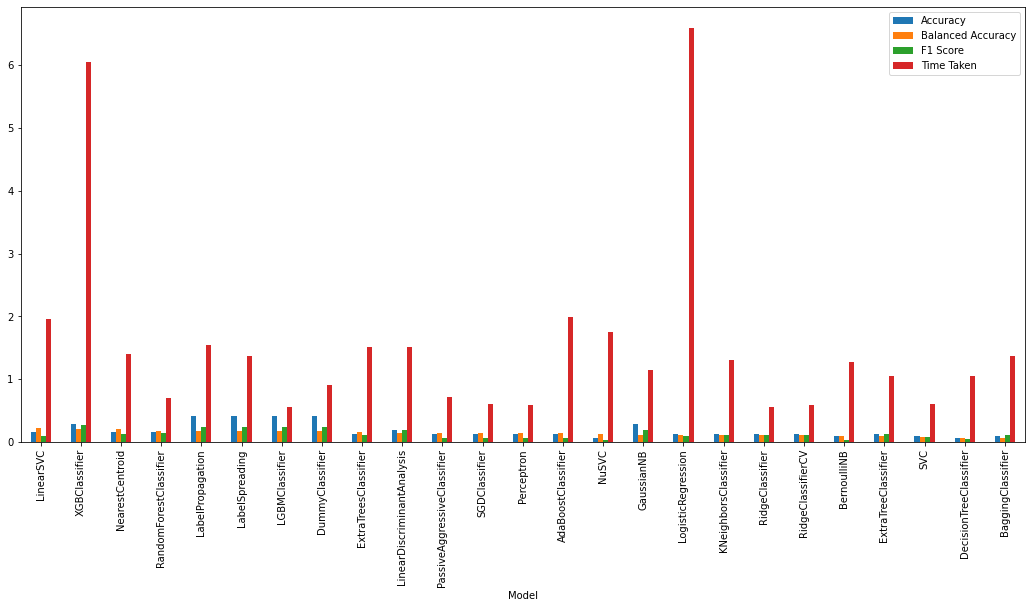

In [345]:
models_c.plot.bar(figsize = (18,8));

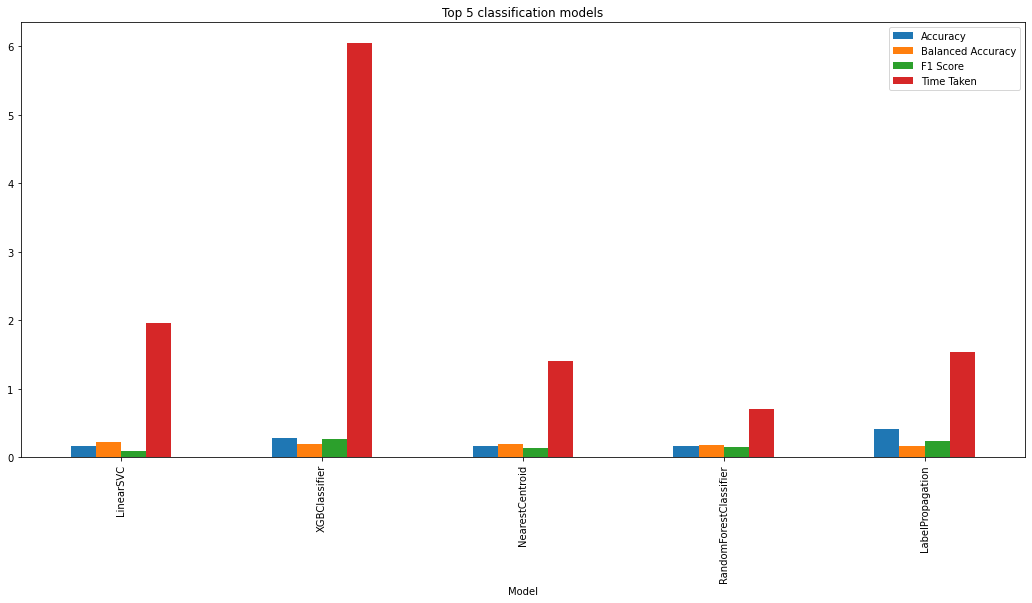

In [346]:
models_c.iloc[0:5].plot.bar(figsize = (18,8), title="Top 5 classification models");

# Discussion
---
<br />

To begin analyzing the LIHC risk factor dataset from The Cancer Genome Atlas, the data and the corresponding annotated data were read into separate Pandas dataframes. With this data read in, it became obvious that the naming conventions were different between the datasets so the annotation data was manipulated so that the variable names matched with those in the LIHC data. With these names now consistent, the data frames were merged into a single data frame and processed to separate out the numeric values from the pathologic stages and create train and test data sets using the sklearn train_test_split function. The original dataset contained 42 samples so the test_size parameter in this function was set to 0.75 because smaller values led to not enough data from each of the 7 pathologic stage (Stage I, Stage II, Stage III, Stage IIIA, Stage IIIC, Stage IV, and Not Available) being present in the test data, therefore the confusion matrix was failing to be produced due to mismatched array sizes.

With the test and train data splits, these values were first fed to a linear SVC model that had a poor model accuracy of 15.6%. Upon looking at the reduced dimensionality PCA plot for the data, there was no clear distinction among the pathologic stages and only 27.92% of the variance was explained by 2 principal components. The confusion matrix and classification report of this model showed the Stage II data performed best in this linear model with 2 of the 5 samples accurately being classified as Stage II.

After the poor linear SVC results, a random forest model was applied to the data with n_estimators (i.e. the number of trees in the forest) set to 500. This resulted in a model with a 28.1% accuracy, significantly outperforming the linear model but still not serving as a good representation of the data. In fact, the only samples that were classified correctly at all were the 9 Stage I samples out of the total 13 in the test data.

After analyzing both the linear SVC model and random forest, the most significant features were plotted for both models. The linear model yielded C4A720, CLVS1157807, SERPINA312, APOF319, and AHCTF125909 as significant features with the highest value being 0.006 while the random forest model produced LOH12CR1118426, DSCR410281, RAB369609, FBLN7129804, and ARIH210425 as significant and 0.0035 as the highest value. Because there was no overlap in significant features between these models and neither one accurately classified the data, marker genes to explore further can be taken from both groups such as C4A720, CLVS1157807, and SERPINA312 from the linear model and LOH12CR1118426 and DSCR410281 from the random forest.

The final model tested with the data was the Lazy Classifier to test multiple models simultaneously then plotted against one another with time, F1 scores, and accuracy included to compare results. The top 5 classification models per the Lazy Classifier were Linear SVC, XGB Classifier, Nearest Centroid, Random Forest, and Label Propagation. Of these, the best F1 score was in the Label Propagation model and the fastest model was the Random Forest. Despite the speed increase from the Random Forest model, the Label Propagation F1 scores demonstrated a better fit for the data, and given the poor results of all models, would be worth exploring further.
